In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

### First, let's prepare the data

In [3]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_POLINA.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

#Creating final dataset
data = pd.merge(specs[['ID_library', 'smiles']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333


In [4]:
# First we need to parse the SMILES and create RDKit 'molecule' objects 
# the 'standardize' function was the one we defined in the first cell with code in this file
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

### There is a problem with some of the smiles as they return none when trying to convert to molecule. 
### The next step is to fix those cases which may be a product of a typo. 

# Looking for None values
corrupted_smiles_idx_list = data[data['MOL'].isnull()].index.tolist() #finding None values
data[data['MOL'].isnull()].head(5)

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL
5164,CBK310016,Cc1nc2c(c(Cl)c(Cl)cc2n1Cc1ccc(cc1)B12OC(=O)CN1...,0.009946,None


In [5]:
data = data.drop([5164])
print(f"There are {len(data)} rows in data")

There are 5171 rows in data


In [6]:
data[data['MOL'].isnull()]

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL


In [7]:
data = data.drop(['MOL'],axis=1)

#Creating molecue objects again
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."


In [8]:
# Check if any of the SMILES contain multiple fragments - 
# this can sometimes cause issues when computing descriptors
data['FRAGS'] =  data['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))
print("Fragments: {0}".format(data['FRAGS'].nunique()))

Fragments: 1


### Now we add the information from the cell profiler

In [9]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchA.drop(['PlateWellCompound','principal component 1','Ypredicted','Intensity_MeanIntensity_illumMITO_cells.1','Labels'], 1)
#Create a vector that takes only the info from the cell profiler. NOTE: it is important to keep the ID intact for future merging
cell_profiler['cell_profiler_vector'] = cell_profiler.apply(lambda r: tuple(r[0:-1]), axis=1).apply(np.array)
cell_profiler.head(2)

<ipython-input-9-f497bdeb16c3>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchA.drop(['PlateWellCompound','principal component 1','Ypredicted','Intensity_MeanIntensity_illumMITO_cells.1','Labels'], 1)


,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,ID_covid,cell_profiler_vector
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,CBK310026,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,CBK310025,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."


In [10]:
#Creating final dataset
data_2 = pd.merge(data, cell_profiler[['ID_covid', 'cell_profiler_vector']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data_2 = data_2.drop(['ID_covid'],axis=1)
data_2.head() 

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL,FRAGS,cell_profiler_vector
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[177.625, 1720.288161, 2334.18884, 1099.896167..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[205.4444444, 1688.236028, 2286.442354, 1091.8..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[204.7777778, 1708.759477, 2319.240635, 1091.1..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[193.8888889, 1647.879668, 2244.319157, 1201.7..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[200.2222222, 1667.427461, 2269.049919, 1138.2..."


## To do:

Add a column with the morgan fingerprints as columns

In [12]:
# Parameters for features
morgan_radius = 3
morgan_n_bits = 2048
fp_n_bits = 2048

# Feature creation
X_morgan, _ = fun.feature_creation(morgan_radius, morgan_n_bits, fp_n_bits, data_2)

morgan_fgp_BatchA = pd.DataFrame(X_morgan)
morgan_fgp_BatchA.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [26]:
type(X_morgan)

numpy.ndarray

In [27]:
X_morgan

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
a = X_morgan.tolist()

In [33]:
data['Morgan_fgp_vector'] = a

In [34]:
data

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL,FRAGS,Morgan_fgp_vector
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...
5167,CBK310019,Cn1c2nc(N3CCNCC3)n(Cc3nnc(o3)-c3ccc(Cl)c(Cl)c3...,0.009855,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5168,CBK310020,Brc1cccc2n(C3CCN(CC3)C(=O)Nc3ccc(I)cc3)c(=O)[n...,0.007715,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
5169,CBK310021,CCOC(=O)c1cnn(c1)-c1cccc2n(C3CCN(CC3)C(=O)Nc3c...,0.010263,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5170,CBK310022,COc1ncc(NC(=O)[C@H]2CC[C@H](CC2)n2c3cccc(N(C)C...,0.008265,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


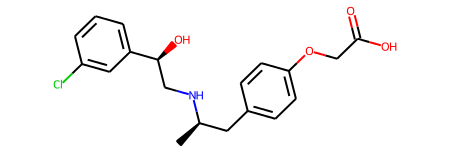

In [35]:
mol = data['MOL'].iloc[0]
mol

In [37]:
b = AllChem.GetMorganFingerprintAsBitVect(mol, morgan_radius, nBits=morgan_n_bits)

In [38]:
np.asarray(b)

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
data['Morgan_fgp_ve'].iloc[0]